<a href="https://colab.research.google.com/github/lIlIlIIIlIIl/DeepLearning_Basic/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


# Install Pytorch, Set data

In [ ]:
!pip install -q torch==2.3.1 torchvision
import torch
print(torch.__version__)

2.3.1+cu121


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import argparse
from copy import deepcopy # Add Deepcopy for args

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
"""
    transforms.ToTensor(): [0,225]사이의 값을 갖는 PIL 이미지나 n차원 행렬을 [0.0, 1.0] 사이의 값을 갖는 Float Tensor형으로 변환
    transforms.Normalize((0.1307,), (0.3081,)): 각 채널의 데이터의 mean이 0.5, standard deviations가 0.5이 되도록 표준화, 이 데이터셋은 R,G,B의 3채널이므로 평균과 표준편차가 각 3개씩 필요
"""

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

partition = {'train': trainset, 'val':valset, 'test':testset}
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_layer,input_size, output_size, hidden_size, act_func, batchnorm, dropout=0):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layer = n_layer
        self.act_func = act_func
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.layers = nn.ModuleList()
        self.BN = nn.ModuleList()

        if self.act_func == 'relu':
            self.act_func = nn.ReLU()

        elif self.act_func == 'tanh':
            self.act_func = nn.Tanh()

        elif self.act_func == 'sigmoid':
            self.act_func = nn.Sigmoid()

        else:
            raise RuntimeError

        self.layers.append(nn.Linear(self.input_size, self.hidden_size))
        for i in range(self.n_layer):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            if self.batchnorm:
                self.BN.append(nn.BatchNorm1d(self.hidden_size))
        self.layers.append(nn.Linear(self.hidden_size, self.output_size))

        self.layers.apply(self._init_weights)

        self.Dropout = nn.Dropout(dropout)


    def _init_weights(self, m):
            if isinstance(m, nn.Linear):
                if self.act_func == 'relu':
                    nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
                    m.bias.data.fill_(0.01)

                elif self.act_func == 'tanh' or self.act_func == 'sigmoid':
                    nn.init.xavier_normal_(m.weight.data)



    def forward(self, x):
        x = self.act_func(self.layers[0](x))
        for i in range(1, self.n_layer - 1):
            if self.batchnrom:
                x = self.BN[i - 1](x)
            x = self.act_func(self.layers[i](x))
            x = self.Dropout(x)
        x = self.layers[self.n_layer - 1](x)
        return x
net = MLP(2, 3072, 10, 100, 'relu', True, 0.6)
print(net)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
  (BN): ModuleList(
    (0-1): 2 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act_func): ReLU()
  (Dropout): Dropout(p=0.6, inplace=False)
)


# Training

In [ ]:
def train(net, partition, args, criterion, optimizer):
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size,
                                            shuffle=True, num_workers=2)
    net.cuda()
    net.train()

    train_correct = 0
    total = 0
    train_loss = 0.0

    for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data # input.shape == [batchsize, 3, 32, 32]
            inputs = inputs.view(-1, 3072) # 1차원으로 펴줘야 함

            inputs = inputs.cuda() # GPU로 값 옮기기
            labels = labels.cuda() # GPU로 값 옮기기
            # input.shape == [batchsize, 3072]

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * train_correct / total

    return net, train_loss, train_acc

# Validation

In [ ]:
def val(net, partition, args, criterion, optimizer):
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False)
    net.cuda()
    net.eval()

    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)

            images = images.cuda()
            labels = labels.cuda()

            # calculate outputs by running images through the network
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

             # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * val_correct / total

    return val_loss, val_acc

#Test

In [ ]:
def test(net, partition, args, criterion, optimizer):
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.test_batch_size,
                                                shuffle=False, num_workers=2)
    net.cuda()
    net.eval()

    test_correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)

            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / total

    return test_acc

#Experiment

In [ ]:
def experiment(args, partition):
    ## 에폭에 따른 loss 및 accuracy값들을 저장하는 리스트 생성 ##
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    net = MLP(args.n_layer,args.input_size, args.output_size, args.hidden_size, args.act_func, args.batchnorm, args.dropout)
    net.cuda()
    criterion = nn.CrossEntropyLoss()

    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    else:
        raise ValueError('In-valid optimizer choice')

    for iter in range(args.epoch):
        net, train_loss, train_acc = train(net, partition, args, criterion, optimizer) # Train
        val_loss, val_acc = val(net, partition, args, criterion, optimizer) # Validation

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch: {}, Train Loss: {:2.2f}, Validation Loss: {:2.2f}, Train Acc: {:2.2f}% ,Validation Acc: {:2.2f}%'.format(iter, train_loss, val_loss, train_acc ,val_acc))
    test_acc = test(net, partition, args, criterion, optimizer) # Test


    result = {} # 리스트들로 채워질 딕셔너리 생성
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs # 리스트로 된 데이터를 추가
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc # 최종 정확도를 추가
    result['val_acc'] = val_acc # 최종 정확도를 추가
    result['test_acc'] = test_acc # 최종 정확도를 추가
    return vars(args), result # vars로 args를 감싸면 딕셔너리가 된다.


# Manage Experiment Result

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch'] # 딕셔너리에서 'epoch'을 키로 갖는 모든 데이터를 삭제, 모델이 잘 돌아가서 epoch을 늘릴 수도 있기 때문. epoch이 달라져도 다른 파일로 생기지 않도록 함
    del setting['test_batch_size'] # 배치 사이즈도 제거

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # result딕셔너리에 setting 딕셔너리를 합치는 update문법
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
# pandas를 이용해 표를 만들어준다.(한 줄이 하나의 딕셔너리로 대응된다.)

# Execute

In [ ]:
# seed를 설정하는 이유는 random값을 얻되 그 값이 변하지 않게 하기 위함
# 모델이 랜덤으로 초기화 되는데, 이 starting point를 맞추어주기 위함

parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()
args.exp_name = "exp1_n_layer_hid_dim" # 실험의 이름 정의

# ===== Model capacity ===== #
args.n_layer = 3
args.input_size = 3072
args.output_size = 10
args.hidden_size = 300
args.act_func = 'relu'

# ===== Regularization ===== #
args.weight_decay = 0.01
args.batchnorm = True
args.dropout = 0.1

# ===== Optimizer, Training ===== #
args.lr = 0.0001
args.epoch = 15
args.optim = 'SGD'

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'epoch'
name_var2 = 'weight_decay'
list_var1 = [15, 30]
list_var2 = [0.001, 0.005 ,0.01, 0.05, 0.1]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # args.name_var1 = var1, 위에서 바꾸면 바로 바뀌도록 자동화
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(deepcopy(args), partition)
        save_exp_result(setting, result)
# 각 실험마다 setting값 딕셔너리와 result 값 딕셔너리를 출력해준다.
# 이 출력 값을 토대로 각 실험 별 파일을 만든다


Namespace(exp_name='exp1_n_layer_hid_dim', n_layer=3, input_size=3072, output_size=10, hidden_size=300, act_func='relu', weight_decay=0.01, batchnorm=True, dropout=0, lr=0.0001, epoch=15, optim='SGD', train_batch_size=256, test_batch_size=1024)
Epoch: 0, Train Loss: 2.19, Validation Loss: 1.74, Train Acc: 37.02% ,Validation Acc: 39.87%
Epoch: 1, Train Loss: 1.64, Validation Loss: 1.63, Train Acc: 44.24% ,Validation Acc: 44.29%
Epoch: 2, Train Loss: 1.55, Validation Loss: 1.61, Train Acc: 46.92% ,Validation Acc: 43.78%
Epoch: 3, Train Loss: 1.48, Validation Loss: 1.58, Train Acc: 49.13% ,Validation Acc: 44.58%
Epoch: 4, Train Loss: 1.43, Validation Loss: 1.60, Train Acc: 50.87% ,Validation Acc: 43.95%
Epoch: 5, Train Loss: 1.39, Validation Loss: 1.50, Train Acc: 52.55% ,Validation Acc: 47.76%
Epoch: 6, Train Loss: 1.35, Validation Loss: 1.51, Train Acc: 53.87% ,Validation Acc: 47.64%
Epoch: 7, Train Loss: 1.32, Validation Loss: 1.45, Train Acc: 54.77% ,Validation Acc: 49.61%
Epoch: 8, T

<Axes: xlabel='lr', ylabel='test_acc'>

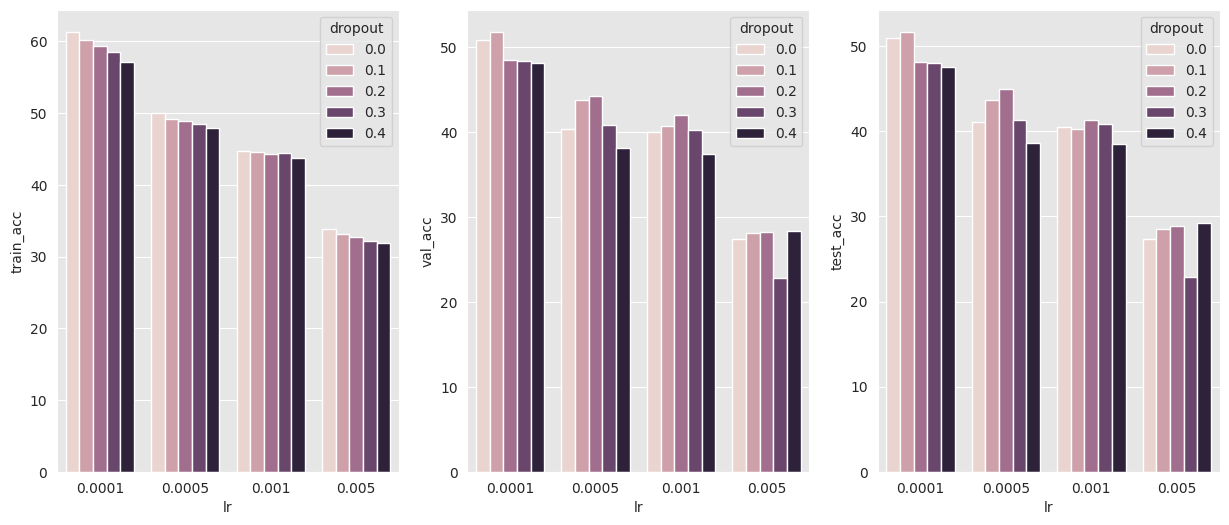

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='weight_decay', y='train_acc', hue='epoch', data=df, ax=ax[0])
sns.barplot(x='weight_decay', y='val_acc', hue='epoch', data=df, ax=ax[1])
sns.barplot(x='weight_decay', y='test_acc', hue='epoch', data=df, ax=ax[2])

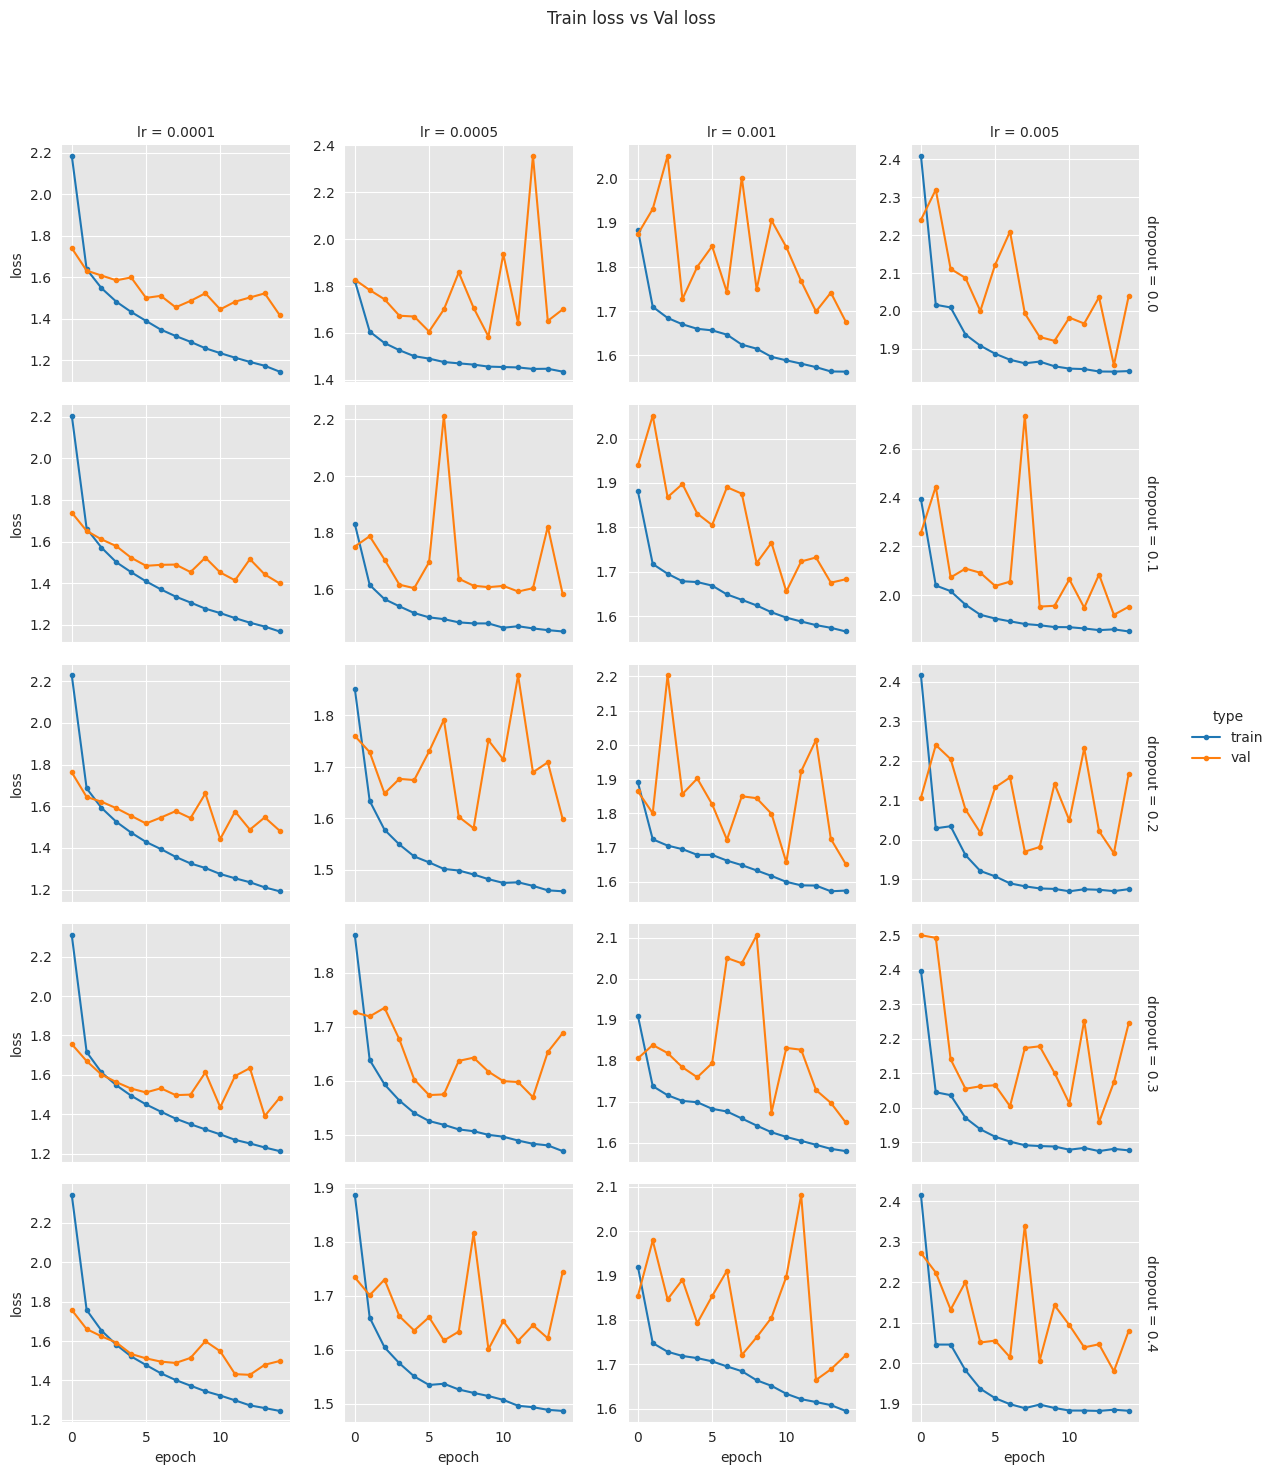

In [ ]:
# Epoch에 따른 val loss와 train loss의 변화를 hidden dimension과 layer에 따라 나타낸 것, 총 5차원의 데이터
var1 = 'epoch' # key가 'n_layer'인 데이터들
var2 = 'weight_decay' # key가 'hid_dim'인 데이터들

df = load_exp_result('exp1')
list_v1 = df[var1].unique() # coulum이 'n_layer'인 것들만 가져옴, 즉 layer 정보만 가져옴 [2, 1, 3]
list_v2 = df[var2].unique() # coulum이 'hid_dim'인 것들만 가져옴, 즉 hidden dimension 정보만 가져옴 [300, 500]
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1] # n_layer가 value1인 row들을 필터링해서 가져옴
        row = row.loc[df[var2]==value2] # 앞서 필터링 한 것들 중 hid_dim이 value2인 row들을 필터링해서 가져옴

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
# 그림이 그려질 그리드를 만들어줌.
# row에는 hidden dim별로, coloum에는 layer별로 배열하도록 함
# train인지 val인지의 타입을 hue로 설정
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
# plt.plot 함수를 각 그리드 칸에서 실행, 이때 각 그래프의 x를 'epoch', y를 'loss'로 함
# 각 그리드에서는 이미 필터링된 데이터들을 기반으로 그래프가 각각 그려진다.(예를 들면 n_layer가 1이며 hid_dim이 300인 데이터는 첫 번째 열 첫 번째 행의 그래프를 그릴 때 사용되도록 필터링 되어서 들어감)
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

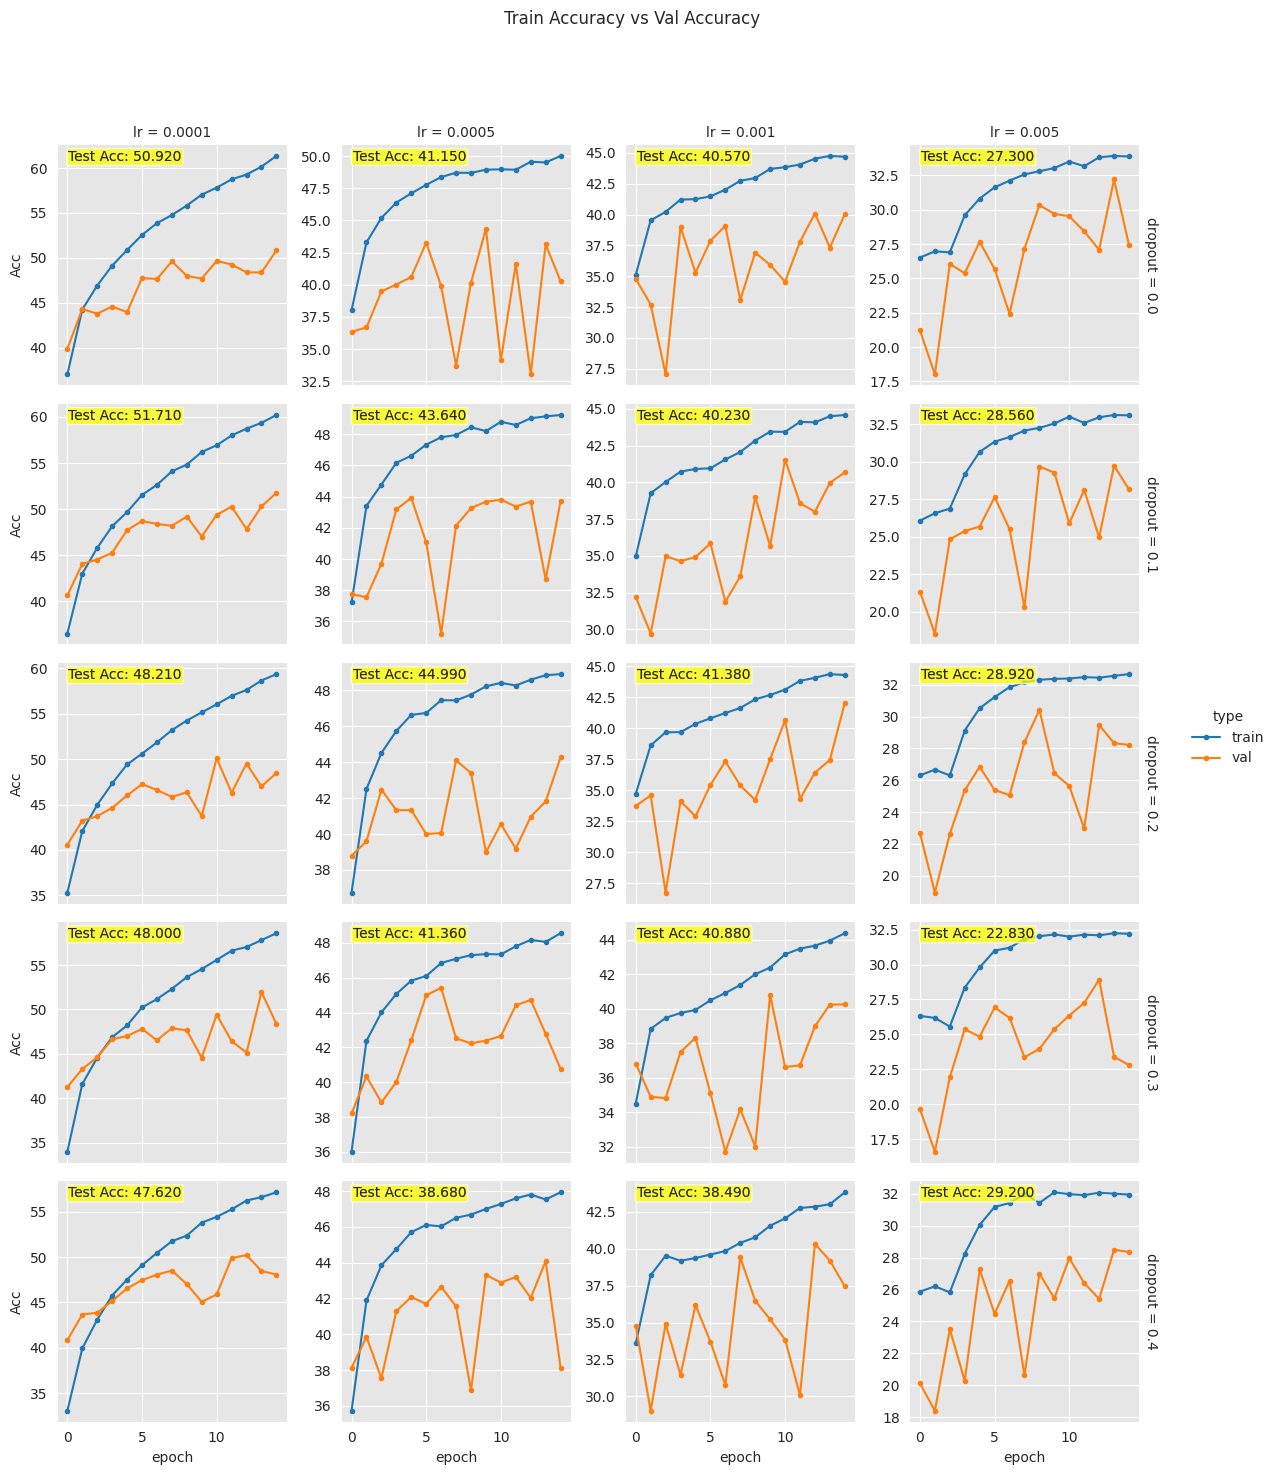

In [ ]:
# Epoch에 따른 val acc와 train acc의 변화를 hidden dimension과 layer에 따라 나타낸 것, 총 5차원의 데이터
var1 = 'epoch'
var2 = 'weight_decay'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]

        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)